<p><img src="https://nerc.ukri.org/nerc/assets/images/logos/nceo/nceologo200.png" align="right" />
</p>
<p>&nbsp;</p>


# Quick visualisation and analysis of Sentinel 2 data over Ghana
### J Gómez-Dans (NCEO & UCL)


## Introduction
This notebooks presents a quick way to extract and analyse data from Sentinel 2. This is just a demo thathighlights a limited regional extent around Tamale (Northern Ghana), but this could be extended to other areas. This is an example where the user might not want to pre-process a lot of data, but will only want to do some limited analyses over a geographically-restricted region, with most of the data being already pre-processed somewhere else. This allows a fairly simple set-up for the user, which needs either a browser, or a very lightweight Python installation in her computer

The notebooks shows how the user can select a region of interest (ROI) online, using e.g. [GeoJSON.io](https://geojson.io), or [Google My Maps](https://www.google.com/mymaps), or any other way you want. You will then extract all the data that pertains to that region of interest and you can play around with it in normal Python. If you want, you can also upload a file to the notebook folder, and point the `roi` variable to this file.

Note that all the data is being accessed remotely, so it can take a little while for the code to complete. However, note that you are only downloading the bits that you require to process your data! It's around 150Gb of raw data that needs downloading and processing!

#### Querying the remote holdings

The remote server has a database of file holdings. In this case, it's data over two Sentinel-2 tiles, but this could be anything. We have a S2 object just for that. 


In [1]:
import datetime as dt
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gdal
gdal.UseExceptions()   
import ipywidgets

import GomezEngine


ds = GomezEngine.DataStorageSentinel2("http://www2.geog.ucl.ac.uk/~ucfajlg/Ghana/database.json")
print(f"Total number of acquisitions: {len(list(ds.data_db.keys())):d}")
print(f"First date: {list(ds.data_db.keys())[0].strftime('%d %b %Y'):s}")
print(f"Last date: {list(ds.data_db.keys())[-1].strftime('%d %b %Y'):s}")


Total number of acquisitions: 50
First date: 02 Jan 2018
Last date: 28 Dec 2018


/home/ucfajlg/.local/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


The previous cell has obtained a listing of all the dates in which we have data available remotely. The data covers an area of arond 100 x 200 km around Tamale, and we have nearly all the Sentinel 2 acquisitions from 2018 (there are quite a few!). 

#### Extracting some actual data

The following cell plots a map with a green dashed box showing you the data that is currently available. You can draw a polygon, and we will extract data from there. 

**Be careful** Select a small area to start with, as otherwise, response times in getting data to and from our experimental server can be long!**Be careful** 

In [26]:

from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, GeoJSON
background = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
m = Map(layers=(background, ), center=(9.45, -1.0), zoom=9)
draw_control = DrawControl()



feature_collection = {
    'type': 'FeatureCollection',
    'features': []
}

def handle_draw(self, action, geo_json):
    """Do something with the GeoJSON when it's drawn on the map"""
    feature_collection['features'].append(geo_json)

draw_control.on_draw(handle_draw)
m.add_layer(GeoJSON(data=json.load(open("roi.geojson", "r")),
                   style = {'color': 'green', 'opacity':1, 
                            'weight':1.9, 'dashArray':'9', 'fillOpacity':0.1}))
m.add_control(draw_control)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

The following bit of code dumps your polygons on a file and queries the server at UCL for the relevant data.

In [11]:
json.dump(feature_collection, open("selected_feature.geojson", 'w'))
analysis_data = ds.extract_band(["B04", "B08"], roi="selected_feature.geojson")


The previous call has subsetted and retrieved the reflectance for bands 4 and 8. We can now proceed to calculate a vegetation index...

In [12]:
dates = sorted(analysis_data['B04'].keys())
ndvi = {k:((analysis_data['B08'][k] - analysis_data['B04'][k])/ \
            (analysis_data['B08'][k] + analysis_data['B04'][k])) for k in dates}


The progress bar aboe can be quite slow. As there are 50 acquisitions in the database, and we're extracting two bands, we need to stream 100 chunks from the remote server at [UCL](http://www.geog.ucl.ac.uk/), which is fairly network intensive.

`analysis_data` is a dictionary, where the first key is the band and the second is the dat eof the acquisition and the item itself is a 2D subset that matches the ROI provided earlier. 

Let's plot a time series...

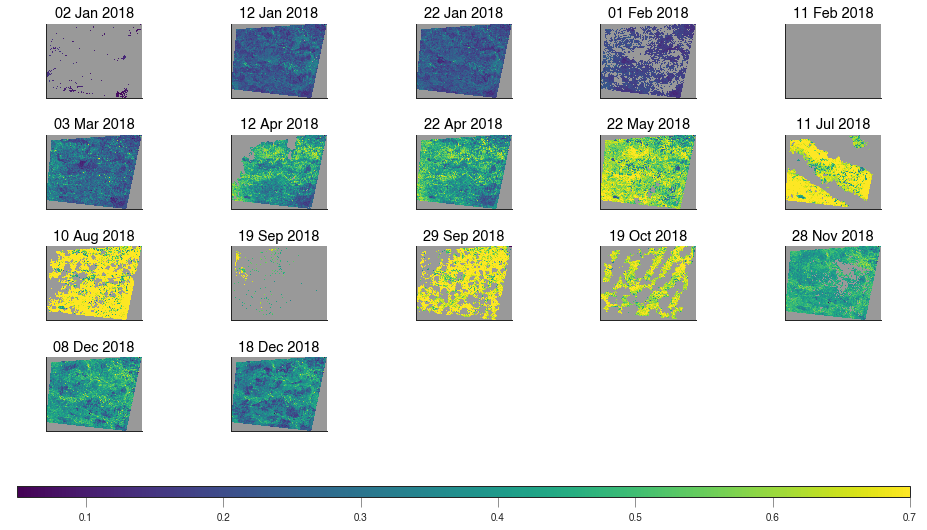

In [28]:
# Work out the number of rows/cols as this changes due to cloudiness and orbit
nr = int(np.sqrt(len(ndvi)))
nc = int(len(ndvi)/nr) + 1

fig, axs = plt.subplots(nrows=nr, ncols=nc, sharex=True, sharey=True, figsize=(16,10))
axs = axs.flatten()
cmap = plt.cm.viridis
cmap.set_bad("0.6")
for ii, (k,v) in enumerate(ndvi.items()):
    im =axs[ii].imshow(v, interpolation="nearest", vmin=0.05,
                       vmax=0.7, cmap=cmap)
    axs[ii].set_title(k.strftime("%d %b %Y"))
    axs[ii].set_xticks([])
    axs[ii].set_yticks([])
[axs[i].set_visible(False) for i in range(ii, nr*nc)]

fig.colorbar(im, ax=axs.tolist(), orientation="horizontal", pad=0.1, aspect=80)

There is clearly some data. We can spot the vegetation period from around June to October/November. However, a pre-filtering of the images that were pre-processed has dropped possible acquisitions during the June to November period, so there could well be extra images over this small area.

Note that the bits in grey have been identified as clouds by the cloud mask. The mask is quite effective as a cloud mask, but pretty hopeless as a cloud shadow mask, so this has to be borne in mind when processing the data...

We can now plot a boxplot of the index distribution. Hopefully, it shows the greening up in June-November...

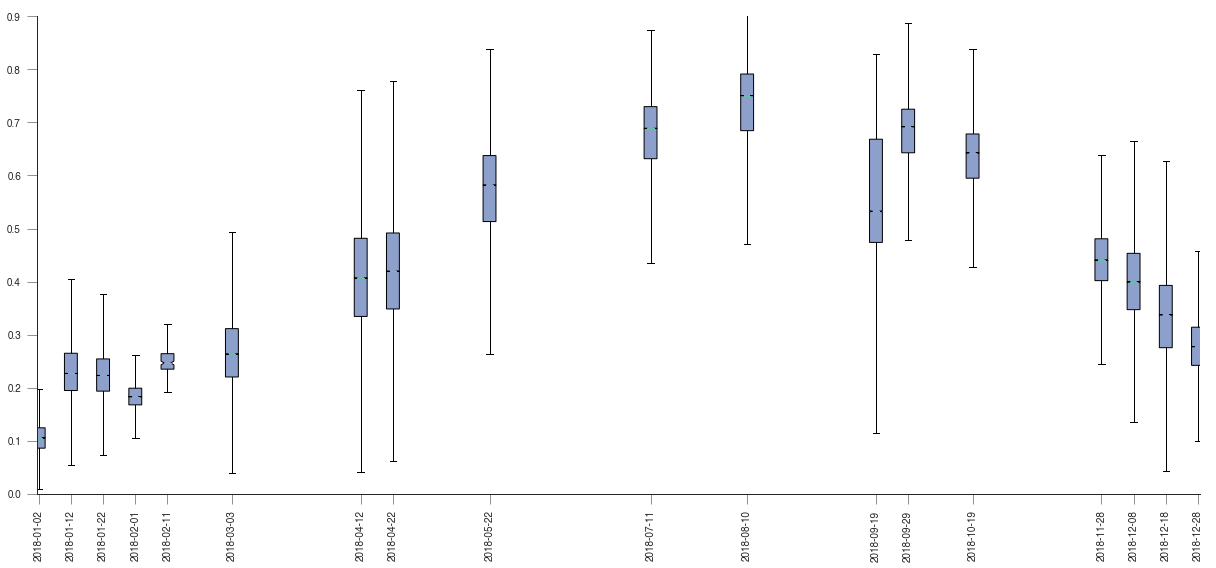

In [31]:
data = []
doys = []
tx = []
for ii, (k,v) in enumerate(ndvi.items()):
    tx.append(k)
    doys.append(int(k.strftime("%j")))
    v = v.flatten()
    data.append(v[np.isfinite(v)])
    
isort = np.argsort(tx)

doys = [doys[i] for i in isort]
tx = [tx[i] for i in isort]
data = [data[i] for i in isort]
plt.figure(figsize=(17,8))    
bp = plt.boxplot(data, positions=doys, notch=True, whis=2, sym="", widths=4,
                 meanline=True, patch_artist=True, labels=tx)
_ = plt.xticks(rotation="vertical")
_ = [patch.set_facecolor("#8DA0CB") for patch in bp['boxes']]
plt.ylim(0, 0.9)
plt.tight_layout()

A very nice temporal behaviour is shown here. The gap during the wet season, the persistent cloudiness results in fewer observations than in the dry season. 

#### Plotting RGB composites

You can also select dates and plot relevant composites. The following snippet allows you to select a data and plot a true-colour RGB composite of it...

In [32]:
def plot_rgb(roi=None, date=None):
    retval = ds.extract_band(["B02", "B03", "B04"], dates=date, roi=roi)
    rgb = 4*np.dstack([retval["B04"][date],retval["B03"][date], retval["B02"][date]])/10000.
    plt.figure(figsize=(15, 15))
    plt.title(date.strftime("%d %b %Y"))
    plt.imshow(rgb, interpolation="nearest")
    plt.tight_layout()
    
ipywidgets.interact_manual(plot_rgb, roi="selected_feature.geojson", date=dates);

interactive(children=(Text(value='selected_feature.geojson', description='roi'), Dropdown(description='date', …